### Important Keyword

- Graph: the flow of the connection of nodes. In other words, it's the agent workflow.
- State: The current snapshot of the application. It's a shared memory for passing data.
- Nodes: tasks or action in form of function
- Edges: connections defining flow (specifying the node/function call)
- Executor: runs the graph and coordinates everything.

In [1]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
import random

In [2]:
load_dotenv(override=True)

True

### Building a SImple Graph with and Without Using LLM

In [12]:
# source of AI response
nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [13]:
# define a state object
class State(BaseModel):
    messages: Annotated[list, add_messages]

In [14]:
# start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [15]:
# create a node
def our_first_node(old_state: State) -> State:

    reply = f"{random.choice(nouns)} are {random.choice(adjectives)}"
    messages = [{"role": "assistant", "content": reply}]

    new_state = State(messages=messages)

    return new_state

# connect the node to the graph
graph_builder.add_node("first_node", our_first_node)

In [16]:
# the edges
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

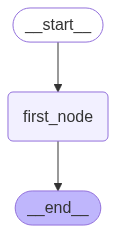

{'messages': [HumanMessage(content='alright', additional_kwargs={}, response_metadata={}, id='6e237070-6d71-4a6f-92df-2c477b7774fa'), AIMessage(content='Pickles are pedantic', additional_kwargs={}, response_metadata={}, id='3bf0c2dc-077b-4895-993e-d74fddbb3f2a')]}
{'messages': [HumanMessage(content='gogh', additional_kwargs={}, response_metadata={}, id='a1899bda-0a03-43ed-a6bc-ce481866dbdd'), AIMessage(content='Zombies are squishy', additional_kwargs={}, response_metadata={}, id='641733aa-47e2-412c-a466-6eba33bb3105')]}


In [17]:
# combine the graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Create a chat gradio application for the graph:

In [10]:
def chat(user_input: str, history):
    message = {"role": "user", "content": user_input}
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content  # AI response displayed in gradio chat

In [11]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi there ', additional_kwargs={}, response_metadata={}, id='95bf8e80-0ce4-4601-bcae-d7e142931a4d'), AIMessage(content='Rainbows are moody', additional_kwargs={}, response_metadata={}, id='e101a4b6-3429-4fa9-9556-5006ba712576')]}
{'messages': [HumanMessage(content='Alright. I get you', additional_kwargs={}, response_metadata={}, id='973bcda5-3989-40e1-be30-0405e1e41a1a'), AIMessage(content='Toasters are squishy', additional_kwargs={}, response_metadata={}, id='6f06823c-a7d7-4684-a93e-af8b59822f73')]}


---
It is important to note that this is a simple example that used random words from list of words as the AI response. We can use an LLM instead.

In [3]:
class State(BaseModel):
    # here, every messages (state) must be passed as list of dictionary. e.g [{"role": "user", "content": "Hi, I am Gab"}]
    # add_messages (reducer): this  is how langgraph will add current message to list of already stroed messages passed as state returend from a node
    messages: Annotated[list, add_messages]


# build a graph with the defined state
graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini") # to be used be the node defined below


def chatbot_node(old_state: State) -> State:
    response = llm.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state


graph_builder.add_node("chatbot", chatbot_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()


In [6]:
# test running teh grapgh before using gradio
print(State(messages=[{"role": "user", "content": "Hi, I am Gab"}]))

graph.invoke(State(messages=[{"role": "user", "content": "Hi, I am Gab"}]))

messages=[{'role': 'user', 'content': 'Hi, I am Gab'}]


{'messages': [HumanMessage(content='Hi, I am Gab', additional_kwargs={}, response_metadata={}, id='48dd0767-af7d-4f78-9cf4-a4f74309fb27'),
  AIMessage(content='Hi Gab! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 12, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C5C1ejWMArcWpBhJ7r6IBVaHRJDQb', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1113c85c-dd48-456a-99ae-206729e4e303-0', usage_metadata={'input_tokens': 12, 'output_tokens': 10, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [7]:
def chat(user_input: str, history):
    state = State(messages=[{"role": "user", "content": user_input}])
    result = graph.invoke(state) # super step: run the graph from start to end using user input to invoke it
    print(result)
    return result['messages'][-1].content # return AI content on chat

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='9fbace83-dff2-4b9f-914a-beebe7945eed'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C5C2aWikOimPEu7P5j8TkPkYdo4CI', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--763c4d57-adfb-4121-803f-b97e5eb72182-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
{'messages': [HumanMessage(content='My 

### Langsmith and Tools
* To set up langsmith account: https://langsmith.com

In [8]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.utilities import GoogleSerperAPIWrapper

#### Langgraph Tool Wrapper

In [10]:
# testing google serper internet search tool
serper = GoogleSerperAPIWrapper()

In [11]:
serper.run("What is the capital of France?")

'Paris is the capital and largest city of France. With an estimated population of 2,048,472 in January 2025 in an area of more than 105 km2 (41 sq mi), ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. The capital of France has been Paris since its liberation in 1944. Paris Capital City Of France In 4K

#### Langgraph tool wrapper

Search engine tool (Built in tool):

In [12]:
from langchain.agents import Tool

tool_search =Tool(
        name="search",
        func=serper.run,
        description="Useful for when you need more information from an online search"
    )

In [13]:
tool_search.invoke("What is the capital of France? Respond with just the capital or Fracne without edding any redundant word.")

'</think> The capital of France is Paris . Missing: Respond just Q: What is the capital city of France? A: Paris is the capital city and also the most populous city in France. If this is going to be a dupe ... Missing: just redundant Besides Paris, what is the capital of France? - Answer: F. Missing: Respond just redundant word. Missing: just redundant Missing: Respond redundant word. Paris has been the capital of France for the last ten centuries. It is the cultural capital of the WHOLE of Europe. Be specific! Capital of France is Paris, Capital letter in the word France is F. 3-23Reply.'

#### Cistomized tool
Push notification tool (Customised tool):

In [15]:
import requests
import os

In [16]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"


def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})
    
    
tool_push = Tool(
    name="send_push_notification",
    func=push,
    description="useful for when you want to send a push notification"
)

tool_push.invoke("Hello, me")

#### Automating tool call in langgraph

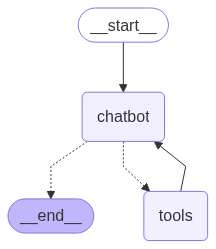

In [17]:
# list all possible tools
tools = [tool_search, tool_push]

# define state
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
# Start the Graph Builder with this State class
graph_builder = StateGraph(State)

# bind all tool to the LLM: it would be able to know the tool to call based on user's input
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

#  create the node that uses the LLM  that's bound with tools
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# add nodes to graph
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))


# add edges: decides if a tool is called on the chartbot nodes or not
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
config = {"configurable": {"thread_id": "1"}}


def chat(user_input: str, history):
    old_state = [{"role": "user", "content": user_input}]
    result = graph.invoke({"messages": old_state}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


### Langgraph checkpointing: Pesisting memories between conversation

#### LangGraph memory server

In [19]:
from langgraph.checkpoint.memory import MemorySaver

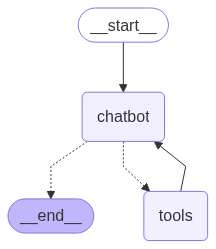

In [20]:
memory = MemorySaver()

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='My name is gabr', additional_kwargs={}, response_metadata={}, id='bdfa38fd-d122-4590-a714-0246ce7c4561'), AIMessage(content='Nice to meet you, Gabr! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 93, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C5D2maice9I8a0unZdBTu8RKYafSl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--2f07e51a-686f-46e6-90e5-3b9b299257c3-0', usage_metadata={'input_tokens': 93, 'output_tokens': 16, 'total_tokens': 109, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), Huma

In [23]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='My name is gabr', additional_kwargs={}, response_metadata={}, id='bdfa38fd-d122-4590-a714-0246ce7c4561'), AIMessage(content='Nice to meet you, Gabr! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 93, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C5D2maice9I8a0unZdBTu8RKYafSl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--2f07e51a-686f-46e6-90e5-3b9b299257c3-0', usage_metadata={'input_tokens': 93, 'output_tokens': 16, 'total_tokens': 109, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'r

In [24]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='My name is gabr', additional_kwargs={}, response_metadata={}, id='bdfa38fd-d122-4590-a714-0246ce7c4561'), AIMessage(content='Nice to meet you, Gabr! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 93, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C5D2maice9I8a0unZdBTu8RKYafSl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--2f07e51a-686f-46e6-90e5-3b9b299257c3-0', usage_metadata={'input_tokens': 93, 'output_tokens': 16, 'total_tokens': 109, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, '

#### SQLite server for memory

In [25]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

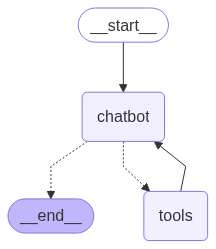

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi, tell me about you', additional_kwargs={}, response_metadata={}, id='dfa20344-82cb-4aea-9e37-c396db3a9328')]}
{'messages': [HumanMessage(content='Hi, tell me about you', additional_kwargs={}, response_metadata={}, id='dfa20344-82cb-4aea-9e37-c396db3a9328'), AIMessage(content="I'm your AI assistant, designed to help you with a wide range of tasks and provide information on various topics. I can assist with answering questions, providing recommendations, and even executing certain functions like sending notifications or conducting searches. My goal is to make your experience as smooth and informative as possible. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 94, 'total_tokens': 160, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_t

In [26]:
db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)


graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()